### Notebook to plot high energy decay timescale associated with pulsating aurora

@author Riley Troyer
science@rileytroyer.com

In [4]:
# Import needed libraries
#import rtroyer_useful_functions as rt_func

import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
from scipy.integrate import quad
import scipy.signal as signal
import scipy.stats as stats
from sklearn.utils import resample
from scipy.stats import pearsonr

In [7]:
# Get a list of directories for inversion data
chemistry_type = 'stanford'
inversion_data_dir = (f'../../data/interim/semeter-troyer-inversions/{chemistry_type}/')
inversion_dirs = os.listdir(inversion_data_dir)
inversion_dirs = [d for d in inversion_dirs if not d.startswith('.')]
inversion_dirs = [inversion_data_dir + d + '/' for d in inversion_dirs]

inversion_dirs = sorted(inversion_dirs)

# Loop through each directory and read inversion results
#...into single file
all_inversion_results = {}

for inversion_dir in inversion_dirs:
    
    # Look for pickle file in directory
    try:
        inversion_results_filename = [f for f in os.listdir(inversion_dir)
                                      if f.endswith('.pickle')][0]
    
        # Read in pickle file
        with open(inversion_dir 
                  + inversion_results_filename, 'rb') as handle:
            inversion_results = pickle.load(handle)
        
        # Set keys of individual day to full dictionary
        for key in inversion_results.keys():
            all_inversion_results[key] = inversion_results[key]
            
    except Exception as e: print(e, inversion_dir)

# Read in file with substorm delay and MLT for PFISR data
with open('../../data/interim/statistics/'
          'pa-pfisr-data-dict-latest.pickle', 'rb') as handle:
    pa_statistics_data = pickle.load(handle)

In [10]:
def get_energy_integrations(energy_bins, energy_flux, threshold):
    """Function to integrate energy flux to get values for statistics.
    INPUT
    energy_bins
        type: array of float
        about: energy bins in eV
    energy_flux
        type: array of float
        about: energy flux in eV m^-2 s^-1
    threshold
        type: float
        about: energy threshold in eV to seperate low and high energies
    OUTPUT
    high_total_energy
        type: float
        about: total energy above threshold in eV
    low_total_energy
        type: float
        about: total energy below threshold in eV
    """

    # Get closest bin to specified energy value
    threshold_i = np.argmin(abs(energy_bins - threshold))
    
    # Get low and high energy contributions
    high_total_energy = np.sum(energy_flux[threshold_i:])
    low_total_energy = np.sum(energy_flux[:threshold_i])
    
    return high_total_energy, low_total_energy

    # Create a new dictionary to store only PA results
pa_inversion_results = {}

# Make array to store all inversion results times
inversion_times = np.array(list(all_inversion_results.keys()))

# Loop through each time and add MLT, substorm delay, and energy calcs
for n, key in enumerate(pa_statistics_data.keys()):
    
    # Update progress
    #rt_func.update_progress((n+1)/len(pa_statistics_data.keys()))
    
    # Find the closest time in full inversion results
    delay = abs(key - inversion_times)
    
    # If there isn't a close time skip
    if np.min(delay).total_seconds() > 60:
        continue

    closest_index = np.argmin(delay)
    closest_time = inversion_times[closest_index]
    
    # Set PA dictionary to inversion results
    pa_inversion_results[closest_time]=all_inversion_results[closest_time]
    
    # Add on statistics data
    d = pa_statistics_data[key]
    pa_inversion_results[closest_time]['low_altitude'] = d['altitude']
    pa_inversion_results[closest_time]['substorm_delay'] = d['delay']
    pa_inversion_results[closest_time]['substorm'] = d['substorm']
    pa_inversion_results[closest_time]['pa_event'] = d['pa event']
    pa_inversion_results[closest_time]['local_time'] = d['local_time']
    pa_inversion_results[closest_time]['mlt_time'] = d['mlt_time']
    pa_inversion_results[closest_time]['ae_index'] = d['ae_index']
    pa_inversion_results[closest_time]['al_index'] = d['al_index']
    
    # Add energy data calculations
    
    # Calculate energy flux
    modeled_flux = pa_inversion_results[closest_time]['modeled_flux']
    
    # To get differential number flux need to
    #...multiply by energy bin widths
    energy_bins = pa_inversion_results[closest_time]['energy_bins']
    bin_widths = energy_bins - np.roll(energy_bins, shift=1)
    #...fix first value
    bin_widths[0] = energy_bins[0] - 0
    
    # To get differential energy flux multiply diff num flux
    #...by energy bins
    energy_flux = modeled_flux * bin_widths * energy_bins
    
    # Get integrated energy fluxes for 30, 50, and 100 keV
    #...integration removes dependences of diff energy flux on eV^-1
    #...note, flux is for entire energy bin, so just have to sum
    #...each bin value
    #...Also make sure to exclude last energy bin
    #...inversion process can cause this to be large
    total_energy = np.sum(energy_flux[0:-1])
    
    (high_energy_10, 
     low_energy_10) = get_energy_integrations(energy_bins[0:-1],
                                              energy_flux[0:-1],
                                              10000)
    
    (high_energy_30, 
     low_energy_30) = get_energy_integrations(energy_bins[0:-1],
                                              energy_flux[0:-1],
                                              30000)
    (high_energy_50, 
     low_energy_50) = get_energy_integrations(energy_bins[0:-1],
                                              energy_flux[0:-1],
                                              50000)
    (high_energy_100, 
     low_energy_100) = get_energy_integrations(energy_bins[0:-1],
                                               energy_flux[0:-1],
                                               100000)
    
    # Write these to dictionaries as well
    pa_inversion_results[closest_time]['total_energy'] = total_energy
    pa_inversion_results[closest_time]['high_10keV'] = high_energy_10
    pa_inversion_results[closest_time]['low_10keV'] = low_energy_10
    pa_inversion_results[closest_time]['high_30keV'] = high_energy_30
    pa_inversion_results[closest_time]['low_30keV'] = low_energy_30
    pa_inversion_results[closest_time]['high_50keV'] = high_energy_50
    pa_inversion_results[closest_time]['low_50keV'] = low_energy_50
    pa_inversion_results[closest_time]['high_100keV'] = high_energy_100
    pa_inversion_results[closest_time]['low_100keV'] = low_energy_100

    # Create list for delay, good high, low, and total energies
delay_list = []
high_list = []
low_list = []
total_list = []

# Loop through each inversion slice and classify based on delay
names = np.array([10, 30, 50, 70, 90, 110, 130, 150, 170])
#names = ['0-20', '20-40', '40-60', '>60']
spectrum_data = {names[0] : {},
                 names[1] : {},
                 names[2] : {},
                 names[3] : {},
                 names[4] : {},
                 names[5] : {},
                 names[6] : {},
                 names[7] : {},
                 names[8] : {},
                }
binary_energy_data = {names[0] : {'low' : {},
                                  'high' : {},
                                  'total' : {}},
                      names[1] : {'low' : {},
                                  'high' : {},
                                  'total' : {}},
                      names[2] : {'low' : {},
                                  'high' : {},
                                  'total' : {}},
                      names[3] : {'low' : {},
                                  'high' : {},
                                  'total' : {}},
                      names[4] : {'low' : {},
                                  'high' : {},
                                  'total' : {}},
                      names[5] : {'low' : {},
                                  'high' : {},
                                  'total' : {}},
                      names[6] : {'low' : {},
                                  'high' : {},
                                  'total' : {}},
                      names[7] : {'low' : {},
                                  'high' : {},
                                  'total' : {}},
                      names[8] : {'low' : {},
                                  'high' : {},
                                  'total' : {}},
                     }

# Count number of events in each bin
events_10 = []
events_30 = []
events_50 = []
events_70 = []
events_90 = []
events_110 = []
events_130 = []
events_150 = []
events_170 = []

# Count different PA events and number of days
selected_events = []
selected_dates = []

# Loop through each key and assign to classification
for key in pa_inversion_results.keys():
    
    # Only include good fits
    converged = pa_inversion_results[key]['converged']
    chi2 = pa_inversion_results[key]['chi2']
    reduced_chi2 = chi2/pa_inversion_results[key]['dof']
    
    # If fit didn't converge, skip
    if converged == False:
        continue
    
    # If chi2 not in reasonable bounds skip
    if (reduced_chi2 < 0) or (reduced_chi2 > 3):
        continue
        
    # Also make sure time is defined
    if np.isnan(pa_inversion_results[key]['substorm_delay']):
        continue
    
    # Get data
    
    # Number flux needs to be multiplied by energy bin width
    energy_bins = pa_inversion_results[key]['energy_bins']
    bin_widths = energy_bins - np.roll(energy_bins, shift=1)
    #...fix first value
    bin_widths[0] = energy_bins[0] - 0
    
    num_flux = pa_inversion_results[key]['modeled_flux']*bin_widths
    
    delay = pa_inversion_results[key]['substorm_delay']
    mlt = key#pa_inversion_results[key]['mlt_time']
    high_energy_10 = pa_inversion_results[key]['high_10keV']
    low_energy_10 = pa_inversion_results[key]['low_10keV']
    high_energy_30 = pa_inversion_results[key]['high_30keV']
    low_energy_30 = pa_inversion_results[key]['low_30keV']
    high_energy_50 = pa_inversion_results[key]['high_50keV']
    low_energy_50 = pa_inversion_results[key]['low_50keV']
    high_energy_100 = pa_inversion_results[key]['high_100keV']
    low_energy_100 = pa_inversion_results[key]['low_100keV']
    total_energy = pa_inversion_results[key]['total_energy']
    
    # Add to PA events and dates list
    selected_events.append(pa_inversion_results[key]['pa_event'])
    selected_dates.append(key.date())
    
    # Set the high and low energy values
    high_energy = high_energy_30
    low_energy = low_energy_30
    
    # Append delay, high, low, and total energies to full list
    delay_list.append(delay)
    high_list.append(high_energy)
    low_list.append(low_energy)
    total_list.append(total_energy)

    
    if delay <= 20:
        n = 0
        spectrum_data[names[n]][mlt] = num_flux
        binary_energy_data[names[n]]['high'][mlt] = high_energy
        binary_energy_data[names[n]]['low'][mlt] = low_energy        
        binary_energy_data[names[n]]['total'][mlt] = total_energy
        events_10.append(pa_inversion_results[key]['pa_event'])
    
    elif (delay > 20) and (delay <= 40):
        n = 1
        spectrum_data[names[n]][mlt] = num_flux
        binary_energy_data[names[n]]['high'][mlt] = high_energy
        binary_energy_data[names[n]]['low'][mlt] = low_energy        
        binary_energy_data[names[n]]['total'][mlt] = total_energy
        events_30.append(pa_inversion_results[key]['pa_event'])
        
    elif (delay > 40) and (delay <= 60):
        n = 2
        spectrum_data[names[n]][mlt] = num_flux
        binary_energy_data[names[n]]['high'][mlt] = high_energy
        binary_energy_data[names[n]]['low'][mlt] = low_energy       
        binary_energy_data[names[n]]['total'][mlt] = total_energy
        events_50.append(pa_inversion_results[key]['pa_event'])
        
    elif (delay > 60) and (delay <= 80):
        n = 3
        spectrum_data[names[n]][mlt] = num_flux
        binary_energy_data[names[n]]['high'][mlt] = high_energy
        binary_energy_data[names[n]]['low'][mlt] = low_energy       
        binary_energy_data[names[n]]['total'][mlt] = total_energy
        events_70.append(pa_inversion_results[key]['pa_event'])
        
    elif (delay > 80) and (delay <= 100):
        n = 4
        spectrum_data[names[n]][mlt] = num_flux
        binary_energy_data[names[n]]['high'][mlt] = high_energy
        binary_energy_data[names[n]]['low'][mlt] = low_energy
        binary_energy_data[names[n]]['total'][mlt] = total_energy
        events_90.append(pa_inversion_results[key]['pa_event'])
        
    elif (delay > 100) and (delay <= 120):
        n = 5
        spectrum_data[names[n]][mlt] = num_flux
        binary_energy_data[names[n]]['high'][mlt] = high_energy
        binary_energy_data[names[n]]['low'][mlt] = low_energy
        binary_energy_data[names[n]]['total'][mlt] = total_energy
        events_110.append(pa_inversion_results[key]['pa_event'])
        
    elif (delay > 120) and (delay <= 140):
        n = 6
        spectrum_data[names[n]][mlt] = num_flux
        binary_energy_data[names[n]]['high'][mlt] = high_energy
        binary_energy_data[names[n]]['low'][mlt] = low_energy
        binary_energy_data[names[n]]['total'][mlt] = total_energy
        events_130.append(pa_inversion_results[key]['pa_event'])
        
    elif (delay > 140) and (delay <= 160):
        n = 7
        spectrum_data[names[n]][mlt] = num_flux
        binary_energy_data[names[n]]['high'][mlt] = high_energy
        binary_energy_data[names[n]]['low'][mlt] = low_energy
        binary_energy_data[names[n]]['total'][mlt] = total_energy
        events_150.append(pa_inversion_results[key]['pa_event'])
        
    elif (delay > 160) and (delay <= 180):
        n = 8
        spectrum_data[names[n]][mlt] = num_flux
        binary_energy_data[names[n]]['high'][mlt] = high_energy
        binary_energy_data[names[n]]['low'][mlt] = low_energy
        binary_energy_data[names[n]]['total'][mlt] = total_energy
        events_170.append(pa_inversion_results[key]['pa_event'])
        
print('0-20 min:', len(spectrum_data[names[0]].keys()))
print('Events: ', len(np.unique(events_10)))
print('20-40 min:', len(spectrum_data[names[1]].keys()))
print('Events: ', len(np.unique(events_30)))
print('40-60 min:', len(spectrum_data[names[2]].keys()))
print('Events: ', len(np.unique(events_50)))
print('60-80 min:', len(spectrum_data[names[3]].keys()))
print('Events: ', len(np.unique(events_70)))
print('80-100 min:', len(spectrum_data[names[4]].keys()))
print('Events: ', len(np.unique(events_90)))
print('100-120 min:', len(spectrum_data[names[5]].keys()))
print('Events: ', len(np.unique(events_110)))
print('120-140 min:', len(spectrum_data[names[6]].keys()))
print('Events: ', len(np.unique(events_130)))
print('140-160 min:', len(spectrum_data[names[7]].keys()))
print('Events: ', len(np.unique(events_150)))
print('160-180 min:', len(spectrum_data[names[8]].keys()))
print('Events: ', len(np.unique(events_170)))

# Get unique PA events
selected_events = np.unique(selected_events)
print('Total number of events:', len(selected_events))
selected_dates = np.unique(selected_dates)
print('Total number of dates:', len(selected_dates))

0-20 min: 509
Events:  30
20-40 min: 480
Events:  27
40-60 min: 310
Events:  20
60-80 min: 238
Events:  18
80-100 min: 168
Events:  13
100-120 min: 90
Events:  6
120-140 min: 92
Events:  6
140-160 min: 50
Events:  5
160-180 min: 13
Events:  2
Total number of events: 53
Total number of dates: 47


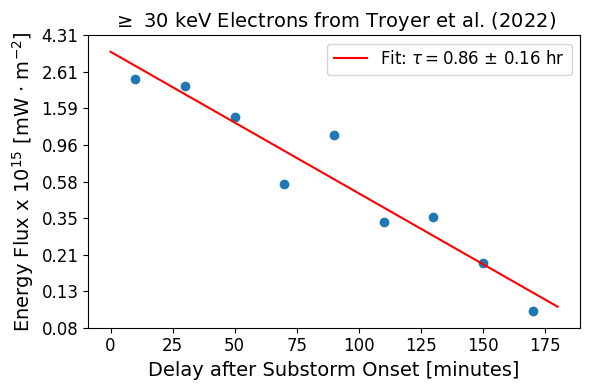

In [14]:
def bootstrap_slope_error(x, y, n_samples):
    """ Function to calculate the error in a slope
    estimated via a linear regression using the bootstrap method. 
    Resample data many times and find the slope each time.
    Standard deviations in these slopes will be the error.
    Requires sklearn.utils.resample
    INPUT
    x
        type: array
        about: independent variable
    y
        type: array
        about: dependent variable
    n_samples
        type: integer
        about: number of resamplings to perform
    OUTPUT
    std
        type: float
        about: standard deviation in the slope
    """
    
    # Array to store slopes in
    sampled_slopes = np.zeros(n_samples)

    for i in range(n_samples):

        # Resample data
        new_x, new_y = resample(x, y, #n_samples=int(len(y)/2),
                                replace=True)

        # Get slope
        slope, intercept, r_value, p_value, std_err = stats.linregress(new_x, new_y)

        # Write to array
        sampled_slopes[i] = slope
        
    return np.std(sampled_slopes)

def distribution_transform(distribution:np.ndarray) -> 'float':

    # Transform the distribution
    distribution = np.log10(distribution)
    
    # Perform fit
    params = stats.norm.fit(distribution)

    # Get detransformed value and errors
    def detransformed(value):
        return 10**(value)

    value =detransformed(params[0])
    error_low = detransformed(params[0] - params[1]/np.sqrt(len(distribution)))
    error_high = detransformed(params[0] + params[1]/np.sqrt(len(distribution)))

    return value

# Data to plot
delay_list = np.array(delay_list)
high_list = np.array(high_list)
low_list = np.array(low_list)
total_list = np.array(total_list)

# Select only delays less than 180
delay_selector = (np.array(delay_list) <= 180)

# x = delay_list[delay_selector]
# y = np.log(high_list[delay_selector])

x = np.array(list(binary_energy_data.keys()))
y = np.log([distribution_transform(list(binary_energy_data[n]['high'].values())) 
                          for n in x])

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Plot fitted line
fit_x = np.linspace(0, 180, len(binary_energy_data.keys()))
fit_y = slope*fit_x + intercept

# Calculate errors
bootstrap_n = 10000
slope_error = bootstrap_slope_error(x, y, bootstrap_n)
tau_error = (2/(slope)**2)*slope_error


# Setup figure
fig, ax = plt.subplots(figsize=(6, 4))

# Setup axis
ax.set_title('$\geq$ 30 keV Electrons from Troyer et al. (2022)', fontsize=14)
ax.set_ylabel(r'Energy Flux x $10^{15}$ [mW $\cdot$ m$^{-2}$]', fontsize=14)
ax.set_xlabel('Delay after Substorm Onset [minutes]', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# Plot data
ax.scatter(x, y)
#ax.scatter(scatter_fit_x, scatter_fit_y, color='k')

# Plot fig
ax.plot(fit_x, fit_y, color='red', label=fr'Fit: $\tau = ${(-1/slope)/60:0.2f} $\pm$ {tau_error/60:0.2f} hr')

# Setup the ticks
yticks = ax.get_yticks()
ax.set_yticks(ticks=yticks)
ax.set_yticklabels(labels=[rf'{n/1e15:0.2f}' for n in np.exp(yticks)])
ax.tick_params(axis='both', labelsize=12)

plt.legend(fontsize=12)
plt.tight_layout()

# plt.savefig('reports/figures/paper/pfisr-pa-high-energy-timescale-recreated.jpg',
#             dpi=300)